## Dimension Reduction & Structural Preservation Analysis

In [1]:
from fcc_utils import *  # contains code necessary for distance preservation analysis, including scanpy and related functions

---
### Preprocessing & Dimension Reduction with `scanpy`

[`AnnData`](https://anndata.readthedocs.io/en/stable/anndata.AnnData.html) objects can be read straight from a compressed `.h5ad` file, containing metadata and reduced dimensions.

Here, we will read in a manually-filtered `.h5ad` file for our human colonic mucosa data.

In [2]:
a = sc.read("Filtered_3907_Data.h5ad") ; a

AnnData object with n_obs × n_vars = 2596 × 29426

These objects have a bunch of useful attributes, and it's easy to calculate some QC metrics and preprocess the raw counts by normalizing per cell and arcsinh-transforming.

In [3]:
# get useful metrics of counts data
a.var["mito"] = a.var_names.str.contains("MT:")
sc.pp.calculate_qc_metrics(a, qc_vars=["mito"], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
a.layers["raw_counts"] = a.X.copy()  # save raw counts in layer
arcsinh(a, layer="raw_counts", norm="l1", scale=1000)  # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']
a.X = a.layers["arcsinh_norm"].copy()  # set normalized counts as .X slot in scanpy object

# see resulting AnnData contents
a

AnnData object with n_obs × n_vars = 2596 × 29426
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

We can use `sc.pp.highly_variable_genes` to identify HVGs in our dataset to be used for PCA and downstream analysis.

In [4]:
sc.pp.highly_variable_genes(a, n_top_genes=2000)

Now we can perform an initial dimension reduction with __principal component analysis__. This dimension-reduced __native space__ will be used to generate further low-dimensional projections with __t-SNE__ and __UMAP__ (__latent spaces__), becoming the reference for our data structure preservation analysis.

/home/cody/.virtualenvs/star/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


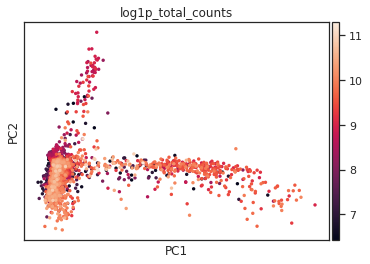

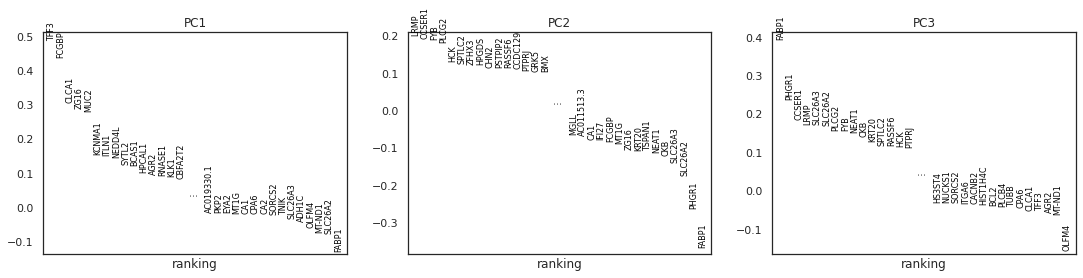

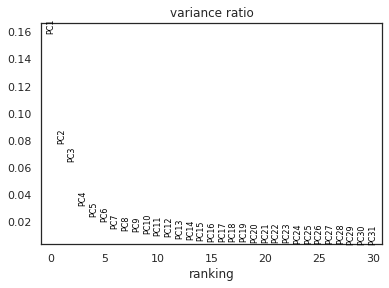

In [5]:
sc.tl.pca(a, n_comps=50)  # perform 50-component PCA on our feature-selected dataset
sc.pl.pca_overview(a, color="log1p_total_counts")  # view first two PCs, feature loadings, and variance

Next, we'll generate a __k-nearest neighbors (kNN)__ graph that describes similarity between all cells in our dataset based on the above 50 PCs. This graph will be used to perform unsupervised clustering and eventually generate a __UMAP__ embedding.

We choose the optimal number of nearest neighbors for graph building and __t-SNE__ analysis (perplexity) as the square-root of the total number of cells:

In [6]:
n_neighbs = int(np.sqrt(a.n_obs))  # determine optimal number of neighbors by sqrt(n_obs)
print("Number of nearest neighbors: {}".format(n_neighbs))

Number of nearest neighbors: 50


Using the __PCA__ output above, we can generate a kNN graph and then perform graph-based __Leiden__ clustering to determine subpopulations.

In [7]:
sc.pp.neighbors(a, n_neighbors=n_neighbs, n_pcs=50, random_state=18)  # generate kNN graph
sc.tl.leiden(a, random_state=18)  # determine dataset clusters

Now we can perform our favorite two-dimensional embeddings for dataset visualization.

Let's start with __t-SNE__, using the optimal `n_neighbs` value as the __perplexity__ parameter and beginning with all 50 principal components.

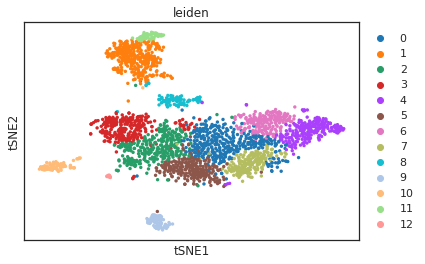

In [8]:
sc.tl.tsne(a, use_rep="X_pca", perplexity=n_neighbs)  # generate t-SNE coordinates
sc.pl.tsne(a, color="leiden")  # plot t-SNE with Leiden cluster overlay

Next, we'll use **PAGA** to generate a coarse-grained graph based on the **Leiden** clusters identified for our dataset. This will be useful in generating initial positions for our __UMAP__ embedding, resulting in faster and more reliable optimization than random initialization.

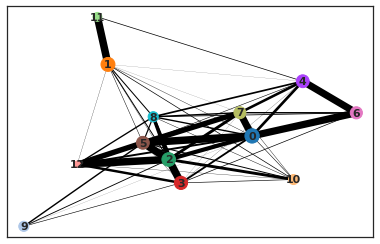

In [9]:
sc.tl.paga(a)  # PAGA uses the kNN graph and Leiden clusters to create a cluster-cluster similarity graph
sc.pl.paga(a)  # plot PAGA graph. Edge thickness and distance describe cluster similarity

Now, we can use **PAGA** positions and the kNN graph generated from 50 principal components to build a two-dimensional **UMAP** embedding.

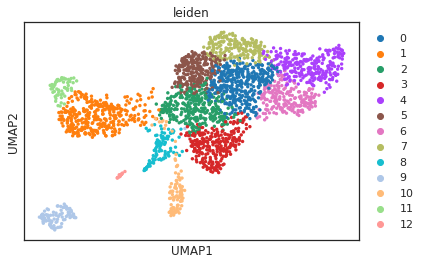

In [10]:
sc.tl.umap(a, init_pos="paga")  # initialize UMAP with PAGA coordinates
sc.pl.umap(a, color="leiden")  # plot embedding with Leiden cluster overlay

To identify cell types, let's perform __differential expression__ analysis and look at top genes in each cluster.

/home/cody/.virtualenvs/star/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


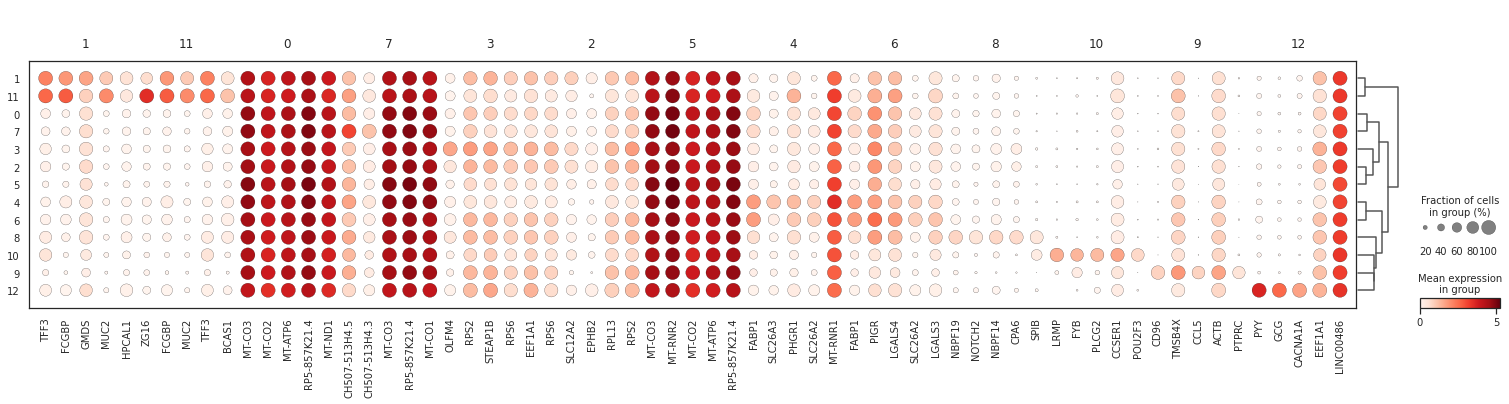

In [29]:
sc.tl.rank_genes_groups(a, groupby="leiden")
sc.pl.rank_genes_groups_dotplot(a, n_genes=5)

---
### Global Structure Preservation Analysis

In order to determine which of our low-dimensional projections (__t-SNE__ or __UMAP__) does a better job of preserving global data structure for our dataset, we can apply the `scipy.spatial.distance.cdist()` function to different parts of our `AnnData` object to get symmetric distance matrices between all cells in the dataset across multiple low-dimensional latent spaces.

In [11]:
%%time
# save distance matrix in AnnData object for easy access
a.uns["X_pca_distances"] = cdist(a.obsm["X_pca"], a.obsm["X_pca"])
a.uns["X_tsne_distances"] = cdist(a.obsm["X_tsne"], a.obsm["X_tsne"])

# calculate simple binary knn graph from the distance matrix above
knn_graph(a.uns["X_pca_distances"], k=n_neighbs, adata=a, save_rep="pca_knn")
knn_graph(a.uns["X_tsne_distances"], k=n_neighbs, adata=a, save_rep="tsne_knn")

CPU times: user 47.7 s, sys: 35.4 ms, total: 47.7 s
Wall time: 3.06 s


Using our `distance_stats` function, we can calculate structural preservation metrics between _latent_ __t-SNE__ space and its corresponding _native_ __PCA__ space.  

In [12]:
%time pca_dist, tsne_dist, corr_stats, EMD = distance_stats(pre=a.uns["X_pca_distances"], post=a.uns["X_tsne_distances"])
knn = knn_preservation(pre=a.uns["pca_knn"]["graph"], post=a.uns["tsne_knn"]["graph"])
print("\nR: {}\nEMD: {}\nKnn Pres. (%): {}".format(round(corr_stats[0],4), round(EMD,4), round(knn, 4)))

Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
CPU times: user 1.72 s, sys: 1.33 s, total: 3.05 s
Wall time: 1.39 s

R: 0.6715
EMD: 0.1082
Knn Pres. (%): 97.5739


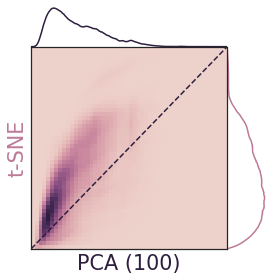

In [13]:
SP_plot(pre_norm=pca_dist, post_norm=tsne_dist, labels=["PCA (100)","t-SNE"]).joint_plot_distance_correlation()

You can also look at the normalized cumulative distance distributions in each projection and calculate the __Wasserstein metric__ or __Earth Mover's Distance__ between the two.

EMD: 0.1082


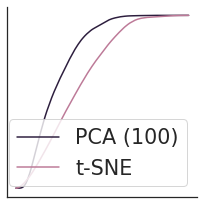

In [14]:
SP_plot(pre_norm=pca_dist, post_norm=tsne_dist, labels=["PCA (100)","t-SNE"], figsize=(3,3)).plot_cumulative_distributions()
print("EMD: {}".format(round(EMD,4)))

__AND__ if we want to do this all very quickly, there's a wrapper function for `AnnData` objects so you don't have to manually calculate and save distance matrices as above.  
Let's do this for our UMAP calculations.

Calculating unique distances for latent space, X_umap
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
50-nearest neighbor calculation for native space, X_pca
50-nearest neighbor calculation for latent space, X_umap
Determining nearest neighbor preservation
Done!
CPU times: user 49.4 s, sys: 1.44 s, total: 50.9 s
Wall time: 4.32 s

R: 0.6124
EMD: 0.0612
Knn Pres.: 97.5174


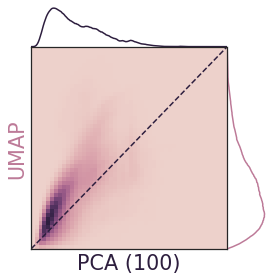

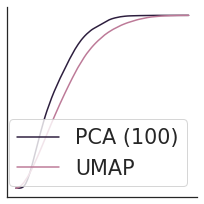

In [15]:
%time corr, EMD, knn = structure_preservation_sc(adata=a, latent="X_umap", native="X_pca", k=n_neighbs)
print("\nR: {}\nEMD: {}\nKnn Pres.: {}".format(round(corr[0],4), round(EMD,4), round(knn, 4)))
SP_plot(pre_norm=a.uns["X_pca_norm_distances"], post_norm=a.uns["X_umap_norm_distances"], labels=["PCA (100)","UMAP"]).joint_plot_distance_correlation()
SP_plot(pre_norm=a.uns["X_pca_norm_distances"], post_norm=a.uns["X_umap_norm_distances"], labels=["PCA (100)","UMAP"], figsize=(3,3)).plot_cumulative_distributions()

---
### Local Structure Preservation Analysis

Now we can look at _local_ data structure within a given cluster of interest. Let's test the structural preservation of goblet cell cluster "1".

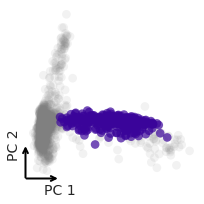

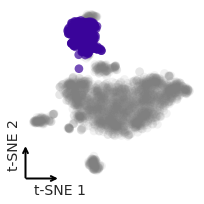

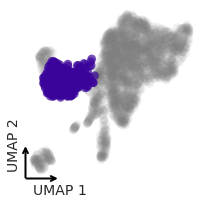

In [30]:
DR_plot(dim_name="PC", figsize=(3,3)).plot_IDs(adata=a, use_rep="X_pca", obs_col="leiden", IDs=["1"])
DR_plot(dim_name="t-SNE", figsize=(3,3)).plot_IDs(adata=a, use_rep="X_tsne", obs_col="leiden", IDs=["1"])
DR_plot(dim_name="UMAP", figsize=(3,3)).plot_IDs(adata=a, use_rep="X_umap", obs_col="leiden", IDs=["1"])

We can subset our distance matrices by `adata.obs['leiden']` and calculate structural preservation metrics as before

In [31]:
subset_uns_by_ID(
    a, 
    uns_keys=["X_pca_distances","X_tsne_distances","X_umap_distances"], 
    obs_col="leiden", 
    IDs=["1"]
)

Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions

R: 0.5325
EMD: 0.0589
CPU times: user 1.7 s, sys: 3.94 s, total: 5.64 s
Wall time: 599 ms


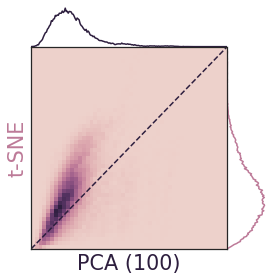

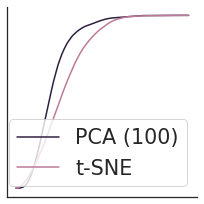

In [32]:
%%time
pca_dist_1, tsne_dist_1, corr_stats_1, EMD_1 = distance_stats(pre=a.uns["X_pca_distances_1"], post=a.uns["X_tsne_distances_1"])
print("\nR: {}\nEMD: {}".format(round(corr_stats_1[0],4), round(EMD_1,4)))
SP_plot(pre_norm=pca_dist_1, post_norm=tsne_dist_1, labels=["PCA (100)","t-SNE"], figsize=(4,4)).joint_plot_distance_correlation()
SP_plot(pre_norm=pca_dist_1, post_norm=tsne_dist_1, labels=["PCA (100)","t-SNE"], figsize=(3,3)).plot_cumulative_distributions()

Let's do the same for __UMAP__ to compare to __t-SNE__.

Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions

R: 0.4318
EMD: 0.1118
CPU times: user 1.98 s, sys: 3.83 s, total: 5.8 s
Wall time: 709 ms


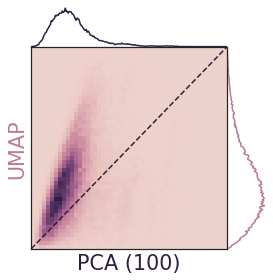

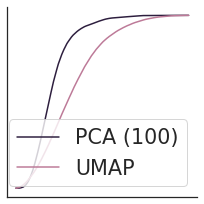

In [33]:
%%time
pca_dist_1, umap_dist_1, corr_stats_1, EMD_1 = distance_stats(pre=a.uns["X_pca_distances_1"], post=a.uns["X_umap_distances_1"])
print("\nR: {}\nEMD: {}".format(round(corr_stats_1[0],4), round(EMD_1,4)))
SP_plot(pre_norm=pca_dist_1, post_norm=umap_dist_1, labels=["PCA (100)","UMAP"], figsize=(4,4)).joint_plot_distance_correlation()
SP_plot(pre_norm=pca_dist_1, post_norm=umap_dist_1, labels=["PCA (100)","UMAP"], figsize=(3,3)).plot_cumulative_distributions()

---
### Neighborhood Preservation

We also have a nice wrapper function to compare the _pairwise distance distributions_ between cells in three clusters.  
Let's look at goblet cells (cluster "1"), tuft cells (cluster "10") and T cells (cluster "9") and plot them in each latent space.

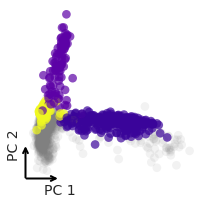

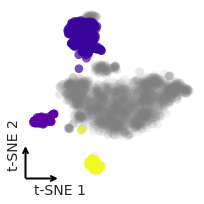

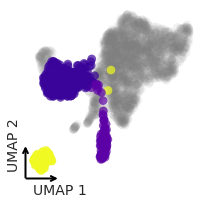

In [34]:
DR_plot(dim_name="PC", figsize=(3,3)).plot_IDs(adata=a, use_rep="X_pca", obs_col="leiden", IDs=["1","9","10"])
DR_plot(dim_name="t-SNE", figsize=(3,3)).plot_IDs(adata=a, use_rep="X_tsne", obs_col="leiden", IDs=["1","9","10"])
DR_plot(dim_name="UMAP", figsize=(3,3)).plot_IDs(adata=a, use_rep="X_umap", obs_col="leiden", IDs=["1","9","10"])

Now run `cluster_arrangement_sc` to see how the local neighborhoods defined between substructures are altered in __t-SNE__ compared to __100-component PCA__.

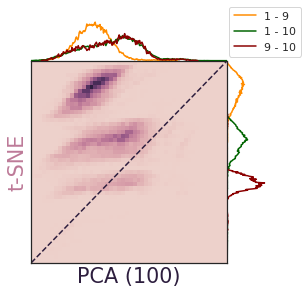

In [35]:
corr_tSNE, EMD_tSNE = cluster_arrangement_sc(
    adata=a, 
    pre=a.obsm["X_pca"], 
    post=a.obsm["X_tsne"], 
    obs_col="leiden", IDs=["1","9","10"], 
    ax_labels=["PCA (100)","t-SNE"], 
    figsize=(4,4)
)

We can do the same thing for __UMAP__.

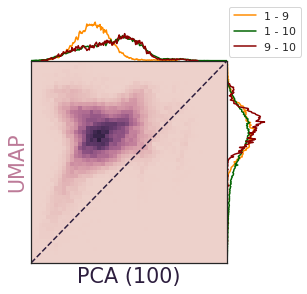

In [36]:
corr_UMAP, EMD_UMAP = cluster_arrangement_sc(
    adata=a, 
    pre=a.obsm["X_pca"], 
    post=a.obsm["X_umap"], 
    obs_col="leiden", IDs=["1","9","10"], 
    ax_labels=["PCA (100)","UMAP"], 
    figsize=(4,4)
)

The correlation and EMD values _between_ each cluster are returned by the above function:

In [37]:
corr_tSNE

[0.6015443068214641, 0.43503730326739387, 0.2065861171848027]

In [38]:
corr_UMAP

[-0.22258939118495977, 0.6667492228767269, -0.43944670788845847]

---
### Topological Cluster Preservation
Finally, to get an idea of the global arrangement of substructures relative to one another, we construct a minimum-spanning tree (MST) graph between cluster centroids in native and latent spaces.  
Permuted edges from one graph to another indicate rearrangement of cluster topology following dimension reduction.

In [39]:
find_centroids(a, use_rep="X_pca", obs_col="leiden")
find_centroids(a, use_rep="X_tsne", obs_col="leiden")
find_centroids(a, use_rep="X_umap", obs_col="leiden")

The above function generates a `networkx` graph in `adata.uns['*_centroid_MST']`.  We can compare the `.edges` attribute of these graphs to determine which ones changed.  
Furthermore, we have a nice visualization function (`DR_plot().plot_centroids()`) to overlay the graph on our embeddings.

5 permuted edges from native space.


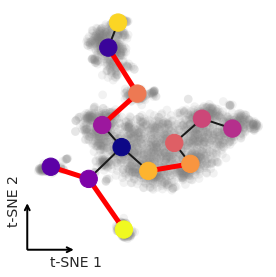

In [40]:
tsne_set = set(a.uns["X_tsne_centroid_MST"].edges).difference(set(a.uns["X_pca_centroid_MST"].edges))
print("{} permuted edges from native space.".format(len(tsne_set)))

DR_plot(dim_name="t-SNE", figsize=(4,4)).plot_centroids(adata=a, obs_col="leiden", use_rep="X_tsne", highlight_edges=tsne_set)

5 permuted edges from native space.


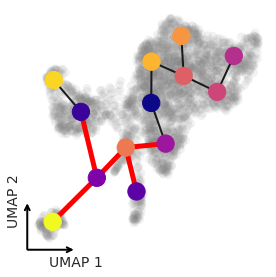

In [41]:
umap_set = set(a.uns["X_umap_centroid_MST"].edges).difference(set(a.uns["X_pca_centroid_MST"].edges))
print("{} permuted edges from native space.".format(len(umap_set)))

DR_plot(dim_name="UMAP", figsize=(4,4)).plot_centroids(adata=a, obs_col="leiden", use_rep="X_umap", highlight_edges=umap_set)